<a href="https://colab.research.google.com/github/mavsoares/aula-4-atividade-6/blob/main/Aula_4_PC_Brasilia_Difusao_MiniDDPM_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 4 — Modelos de Difusão (Diffusion) | Hands-on (PC Brasília)

**Fabiano Miranda — Fundamentos de Deep Learning (Aula 4)**  
**Data:** 28/01/2026

> Objetivo: entender e **codar** um modelo de difusão **do zero (mini-DDPM)** em imagens simples (MNIST), explicando **cada etapa**:  
> **(1)** ruído + cronograma (**noise schedule**), **(2)** processo direto *q(x_t|x0)*, **(3)** rede que prevê ruído (**U-Net pequena**), **(4)** treinamento, **(5)** amostragem (gerar imagem a partir de ruído).

---

## Por que “difusão” é o estado da arte?
- GANs mostraram que “gerar é possível”.  
- Difusão mostrou **como gerar com estabilidade e controle** (guidance, steps, condicionamento, etc.).  
- A ideia-chave é simples e poderosa:

> **Difusão aprende a transformar ruído em informação** (desfazer o caos).

---

## Contexto (conexão com as aulas 1–3)
- **Aula 1 (Deep Learning):** redes aprendem representações; backprop; convolução; U-Net.  
- **Aula 2 (ML + Dados):** modelos aprendem padrões a partir de dados; distribuição; generalização.  
- **Aula 3 (GANs):** geração via competição; comparação histórica.  
- **Aula 4 (Difusão):** geração via **processo reversível** (ruído → imagem).

---

# Sumário do que vamos construir
1. Importar libs + fixar seed  
2. Baixar MNIST e visualizar amostras  
3. Definir **noise schedule** (β, α, ᾱ)  
4. Implementar o **processo direto**: `q(x_t | x_0)` (add noise)  
5. Criar uma **U-Net pequena** que prevê o ruído ε  
6. Treinar por algumas épocas (rápido, didático)  
7. Gerar novas imagens (amostragem reversa)  
8. Extensões para projeto (condicionamento, texto, etc.)

> ⚠️ Observação: este notebook é didático. Para modelos grandes (Stable Diffusion etc.), usamos pesos pré-treinados.


## Nota importante (ética e uso responsável)
Este hands-on é **educacional**. Em aplicações reais (forense, investigação, perícia), geração de imagens requer:
- **cadeia de custódia**, auditoria, logs, reprodutibilidade;
- políticas claras para **evitar fabricação de evidências**;
- uso preferencial para **simulação, treinamento, robustez, restauração**, nunca para “inventar fatos”.


In [1]:
# ============================
# 1) Setup do ambiente
# ============================
# Dica (Colab): Runtime > Change runtime type > GPU
# No AntiGravity: normalmente roda com CPU; vai ser mais lento.
!pip install kaggle
!pip install torch torchvision diffusers transformers accelerate matplotlib numpy pillow
import math
import os
import random
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

plt.rcParams["figure.dpi"] = 120
import json
import os

# Suas credenciais do Kaggle
kaggle_credentials = {
    "username": "fabianemiranda",
    "key": "KGAT_eb24ddc31e0938f244836f9b9c184af6"
}

# Criar diretório .kaggle
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Salvar o arquivo kaggle.json
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
with open(kaggle_path, 'w') as f:
    json.dump(kaggle_credentials, f)

# Dar permissões corretas
os.chmod(kaggle_path, 0o600)

print("✓ Arquivo kaggle.json criado com sucesso!")
print(f"✓ Localização: {kaggle_path}")
!kaggle datasets list
!kaggle datasets download -d hojjatk/mnist-dataset


Device: cuda
✓ Arquivo kaggle.json criado com sucesso!
✓ Localização: /root/.kaggle/kaggle.json
ref                                                                 title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
saidaminsaidaxmadov/chocolate-sales                                 Chocolate Sales                                         468320  2026-01-04 14:23:35.490000          10372        167  1.0              
rockyt07/social-media-user-analysis                                 Social Media User Analysis                           247842357  2026-01-14 02:28:41.970000           6455        136  1.0              
vishardmehta/indian-engineering-college-placement-dataset           Indian Engineering C

In [2]:
# ============================
# 2) Dataset MNIST (imagens 28x28)
# ============================
# Baixar o dataset MNIST do Kaggle
import os
import shutil
import zipfile

# Criar a estrutura de pastas que o PyTorch espera
raw_folder = "./data/mnist_kaggle/MNIST/raw"
os.makedirs(raw_folder, exist_ok=True)

zip_path = "./mnist-dataset.zip"
extract_dir = "./data/mnist_kaggle"

if not os.path.exists(extract_dir):
  os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Conteúdo de mnist-dataset.zip extraído para {extract_dir}")

# Extrair o arquivo zipado

# Arquivos que o PyTorch espera
files_to_move = [
    "train-images.idx3-ubyte",
    "train-labels.idx1-ubyte",
    "t10k-images.idx3-ubyte",
    "t10k-labels.idx1-ubyte"
]

print("Organizando arquivos para o PyTorch...")
print("="*60)

# Mover/copiar arquivos para a pasta correta
for filename in files_to_move:
    src = f"./data/mnist_kaggle/{filename}"
    dst = f"{raw_folder}/{filename}"

    if os.path.exists(src):
        if not os.path.exists(dst):
            shutil.copy2(src, dst)
            print(f"✓ Copiado: {filename}")
        else:
            print(f"⊙ Já existe: {filename}")
    else:
        print(f"✗ Não encontrado: {filename}")

print("\n" + "="*60)
print("Verificando estrutura final:")
print(f"\n📁 {raw_folder}:")
if os.path.exists(raw_folder):
    for f in os.listdir(raw_folder):
        filepath = os.path.join(raw_folder, f)
        size = os.path.getsize(filepath) / (1024 * 1024)
        print(f"  ✓ {f} ({size:.2f} MB)")
else:
    print("  ✗ Pasta não existe!")


Conteúdo de mnist-dataset.zip extraído para ./data/mnist_kaggle
Organizando arquivos para o PyTorch...
⊙ Já existe: train-images.idx3-ubyte
⊙ Já existe: train-labels.idx1-ubyte
⊙ Já existe: t10k-images.idx3-ubyte
⊙ Já existe: t10k-labels.idx1-ubyte

Verificando estrutura final:

📁 ./data/mnist_kaggle/MNIST/raw:
  ✓ t10k-labels-idx1-ubyte (0.01 MB)
  ✓ train-labels.idx1-ubyte (0.06 MB)
  ✓ train-images-idx3-ubyte (44.86 MB)
  ✓ t10k-labels.idx1-ubyte (0.01 MB)
  ✓ train-images.idx3-ubyte (44.86 MB)
  ✓ t10k-images-idx3-ubyte (7.48 MB)
  ✓ train-labels-idx1-ubyte (0.06 MB)
  ✓ t10k-images.idx3-ubyte (7.48 MB)


Renomeando arquivos...
✓ train-images.idx3-ubyte → train-images-idx3-ubyte
✓ train-labels.idx1-ubyte → train-labels-idx1-ubyte
✓ t10k-images.idx3-ubyte → t10k-images-idx3-ubyte
✓ t10k-labels.idx1-ubyte → t10k-labels-idx1-ubyte

Verificando arquivos finais:
  ✓ t10k-labels-idx1-ubyte (0.01 MB)
  ✓ train-labels.idx1-ubyte (0.06 MB)
  ✓ train-images-idx3-ubyte (44.86 MB)
  ✓ t10k-labels.idx1-ubyte (0.01 MB)
  ✓ train-images.idx3-ubyte (44.86 MB)
  ✓ t10k-images-idx3-ubyte (7.48 MB)
  ✓ train-labels-idx1-ubyte (0.06 MB)
  ✓ t10k-images.idx3-ubyte (7.48 MB)

✓ Arquivos prontos para o PyTorch!

✓ MNIST carregado! 60000 imagens no total
✓ Usando subset de 10000 imagens


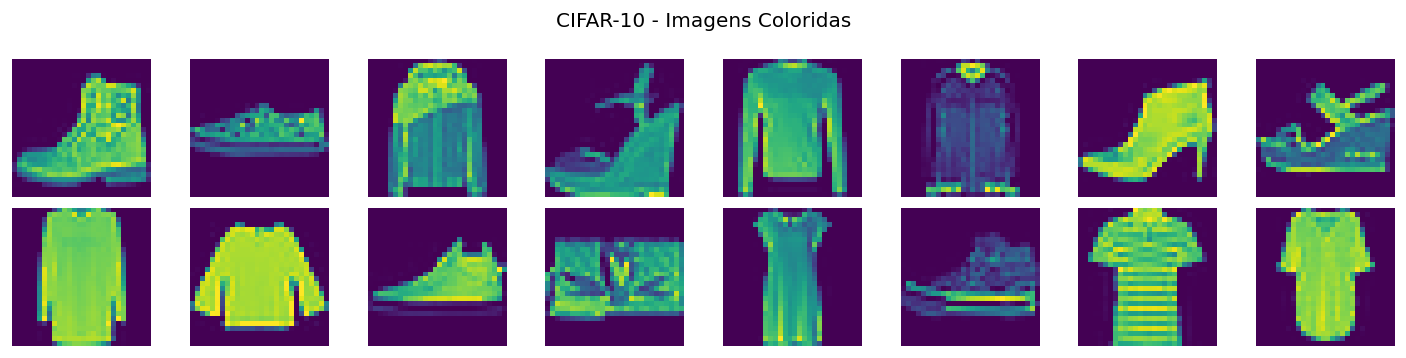

Batch shape: torch.Size([128, 1, 28, 28])
Labels: [9, 7, 4, 5, 2, 4, 9, 5, 6, 6]


In [3]:

import os
import shutil

raw_folder = "./data/mnist_kaggle/MNIST/raw"

# Mapeamento: nome atual → nome que o PyTorch espera
rename_map = {
    "train-images.idx3-ubyte": "train-images-idx3-ubyte",
    "train-labels.idx1-ubyte": "train-labels-idx1-ubyte",
    "t10k-images.idx3-ubyte": "t10k-images-idx3-ubyte",
    "t10k-labels.idx1-ubyte": "t10k-labels-idx1-ubyte"
}

print("Renomeando arquivos...")
print("="*60)

for old_name, new_name in rename_map.items():
    src = f"./data/mnist_kaggle/{old_name}"
    dst = f"{raw_folder}/{new_name}"

    if os.path.exists(src):
        shutil.copy2(src, dst)
        print(f"✓ {old_name} → {new_name}")
    else:
        print(f"✗ Não encontrado: {old_name}")

print("\n" + "="*60)
print("Verificando arquivos finais:")
for filename in os.listdir(raw_folder):
    filepath = os.path.join(raw_folder, filename)
    size = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  ✓ {filename} ({size:.2f} MB)")

print("\n✓ Arquivos prontos para o PyTorch!")
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),                  # [0,1]
    transforms.Lambda(lambda x: x * 2 - 1)  # [-1,1] para estabilizar
])

# Carregar MNIST (agora na estrutura correta)
train_ds = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
# Criar subset
subset_size = 10000
indices = np.random.choice(len(train_ds), size=subset_size, replace=False)
train_subset = Subset(train_ds, indices)

# DataLoader
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)

print(f"\n✓ MNIST carregado! {len(train_ds)} imagens no total")
print(f"✓ Usando subset de {len(train_subset)} imagens")
import matplotlib.pyplot as plt

def show_images_color(x, title="Amostras", n=16):
    x = x[:n].detach().cpu()
    x = (x + 1) / 2  # [-1,1] -> [0,1]

    # Criar grid
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 8, figsize=(12, 3))
    axes = axes.flatten()

    for i in range(n):
        img = x[i].permute(1, 2, 0)  # CHW -> HWC
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Testar
x0, y0 = next(iter(train_loader))
show_images_color(x0, "CIFAR-10 - Imagens Coloridas")
print(f"Batch shape: {x0.shape}")  # Será [128, 3, 32, 32]
print(f"Labels: {y0[:10].tolist()}")

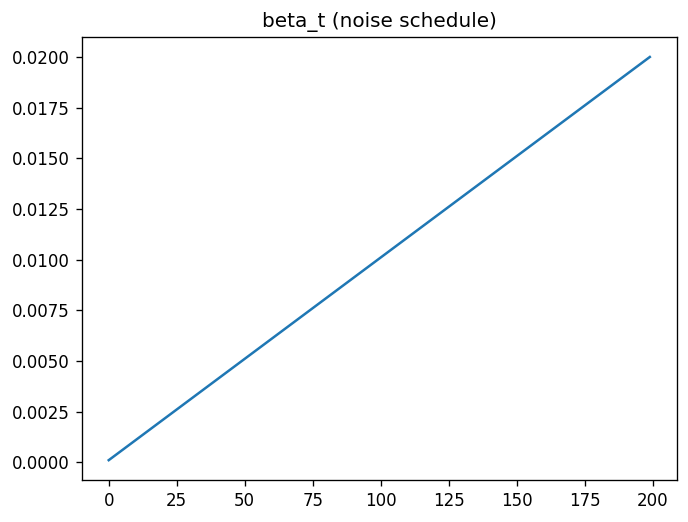

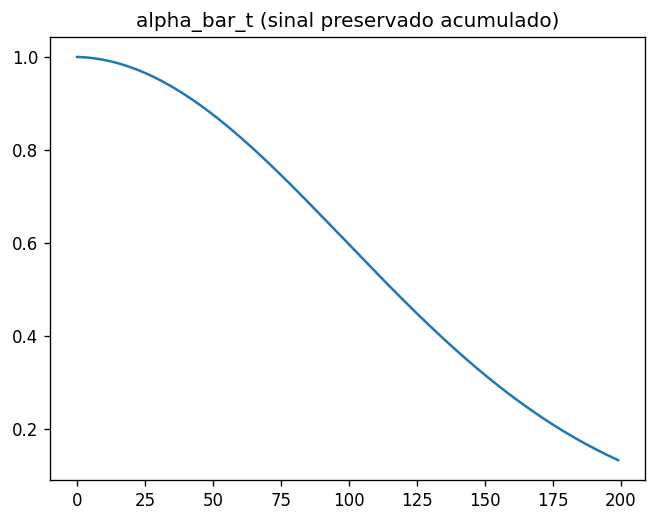

beta[0], beta[-1]: 9.999999747378752e-05 0.019999999552965164
alpha_bar[0], alpha_bar[-1]: 0.9998999834060669 0.1321827620267868


In [4]:
# ============================
# 3) Noise Schedule (β, α, ᾱ)
# ============================

T = 200  # passos (para aula: 100–300 ok; modelos grandes usam 1000+)

beta_start = 1e-4
beta_end = 0.02
beta = torch.linspace(beta_start, beta_end, T)  # (T,)

alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)         # (T,)

beta = beta.to(device)
alpha = alpha.to(device)
alpha_bar = alpha_bar.to(device)

import matplotlib.pyplot as plt
plt.figure(); plt.plot(beta.detach().cpu().numpy()); plt.title("beta_t (noise schedule)"); plt.show()
plt.figure(); plt.plot(alpha_bar.detach().cpu().numpy()); plt.title("alpha_bar_t (sinal preservado acumulado)"); plt.show()

print("beta[0], beta[-1]:", float(beta[0]), float(beta[-1]))
print("alpha_bar[0], alpha_bar[-1]:", float(alpha_bar[0]), float(alpha_bar[-1]))


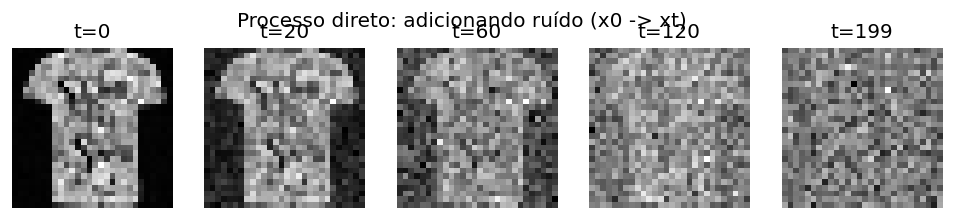

In [5]:
# ============================
# 4) Processo direto: q(x_t | x_0)
# ============================
# x_t = sqrt(alpha_bar_t)*x0 + sqrt(1-alpha_bar_t)*epsilon

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = alpha_bar[t].view(-1, 1, 1, 1)
    return torch.sqrt(a_bar) * x0 + torch.sqrt(1.0 - a_bar) * noise, noise

x0, _ = next(iter(train_loader))
x0 = x0.to(device)

ts = torch.tensor([0, 20, 60, 120, 199], device=device)
imgs = []
for tval in ts:
    t = torch.full((x0.size(0),), int(tval.item()), device=device, dtype=torch.long)
    xt, _ = q_sample(x0, t)
    imgs.append(xt)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 2))
for i, tval in enumerate(ts):
    plt.subplot(1, len(ts), i+1)
    im = imgs[i][0].detach().cpu()
    im = (im + 1) / 2
    plt.imshow(im.squeeze(0), cmap="gray")
    plt.title(f"t={int(tval)}")
    plt.axis("off")
plt.suptitle("Processo direto: adicionando ruído (x0 -> xt)")
plt.show()


# 5) Modelo que prevê o ruído (ε) — U-Net pequena

Treinamos com:

> **loss = MSE(ε_pred, ε_real)**

## “Onde entra o tempo t?”
A rede precisa saber o nível de ruído. Vamos usar **embedding de tempo sinusoidal**.


In [6]:
# ============================
# 5.1) Embedding de tempo (sinusoidal)
# ============================
import math
import torch
import torch.nn.functional as F

def sinusoidal_time_embedding(t, dim=64):
    device = t.device
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=device).float() / (half - 1))
    args = t.float().view(-1, 1) * freqs.view(1, -1)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

t_test = torch.tensor([0, 10, 199], device=device)
emb = sinusoidal_time_embedding(t_test, dim=64)
print("t:", t_test)
print("embedding shape:", emb.shape)
print("embedding[0][:6]:", emb[0][:6])


t: tensor([  0,  10, 199], device='cuda:0')
embedding shape: torch.Size([3, 64])
embedding[0][:6]: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')


In [7]:
# ============================
# 5.2) U-Net pequena (MNIST)
# ============================
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Linear(time_dim, out_ch)
        self.gn1 = nn.GroupNorm(8, out_ch)
        self.gn2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.conv1(x)
        h = self.gn1(h)
        h = self.act(h)

        t = self.time_mlp(t_emb).view(-1, h.size(1), 1, 1)
        h = h + t

        h = self.conv2(h)
        h = self.gn2(h)
        h = self.act(h)
        return h + self.res_conv(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.block = ResidualBlock(in_ch, out_ch, time_dim)
        self.pool = nn.AvgPool2d(2)

    def forward(self, x, t_emb):
        h = self.block(x, t_emb)
        return self.pool(h), h

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.block = ResidualBlock(in_ch, out_ch, time_dim)

    def forward(self, x, skip, t_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.block(x, t_emb)

class MiniUNet(nn.Module):
    def __init__(self, time_dim=64, base=32):
        super().__init__()
        self.time_dim = time_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        self.in_conv = nn.Conv2d(1, base, 3, padding=1)

        self.down1 = Down(base, base*2, time_dim)      # 28 -> 14
        self.down2 = Down(base*2, base*4, time_dim)    # 14 -> 7

        self.bot1 = ResidualBlock(base*4, base*4, time_dim)
        self.bot2 = ResidualBlock(base*4, base*4, time_dim)

        self.up2 = Up(base*4 + base*4, base*2, time_dim)  # 7 -> 14
        self.up1 = Up(base*2 + base*2, base, time_dim)    # 14 -> 28

        self.out_conv = nn.Conv2d(base, 1, 3, padding=1)  # prevê epsilon

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, dim=self.time_dim)
        t_emb = self.time_mlp(t_emb)

        x = self.in_conv(x)
        x, skip1 = self.down1(x, t_emb)
        x, skip2 = self.down2(x, t_emb)

        x = self.bot1(x, t_emb)
        x = self.bot2(x, t_emb)

        x = self.up2(x, skip2, t_emb)
        x = self.up1(x, skip1, t_emb)

        return self.out_conv(x)

model = MiniUNet(time_dim=64, base=32).to(device)

x0, _ = next(iter(train_loader))
x0 = x0.to(device)
t = torch.randint(0, T, (x0.size(0),), device=device)
eps_pred = model(x0, t)
print("x0:", x0.shape, "eps_pred:", eps_pred.shape)


x0: torch.Size([128, 1, 28, 28]) eps_pred: torch.Size([128, 1, 28, 28])


# 6) Treinamento (didático)
Treino do DDPM:
1. pega `x0`
2. sorteia `t`
3. cria `xt` e `ε_real`
4. rede prevê `ε_pred`
5. loss = MSE(ε_pred, ε_real)


Epoch 1/6 - loss: 0.3766
Epoch 2/6 - loss: 0.1988
Epoch 3/6 - loss: 0.1587
Epoch 4/6 - loss: 0.1453
Epoch 5/6 - loss: 0.1357
Epoch 6/6 - loss: 0.1298


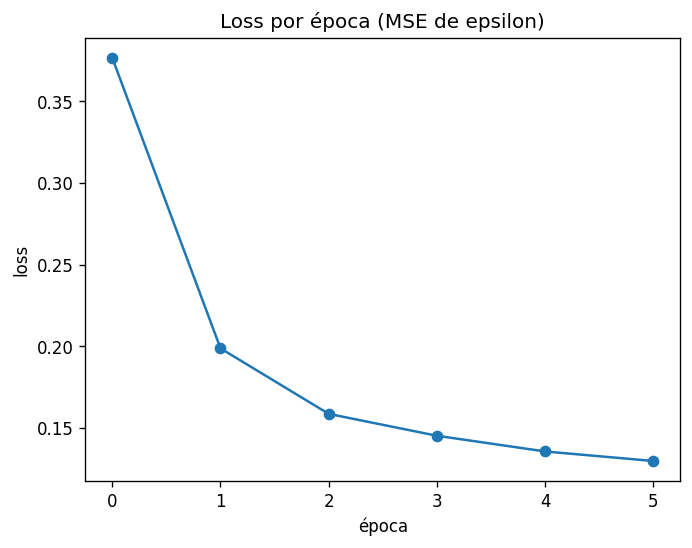

Checkpoint salvo em: checkpoints/mini_ddpm_mnist.pth


In [8]:
# ============================
# 6) Loop de treinamento
# ============================
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

lr = 2e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def train_one_epoch(model, loader):
    model.train()
    losses = []
    for x0, _ in loader:
        x0 = x0.to(device)
        t = torch.randint(0, T, (x0.size(0),), device=device)
        xt, eps = q_sample(x0, t)
        eps_pred = model(xt, t)
        loss = F.mse_loss(eps_pred, eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

epochs = 6
history = []
for ep in range(1, epochs+1):
    mean_loss = train_one_epoch(model, train_loader)
    history.append(mean_loss)
    print(f"Epoch {ep}/{epochs} - loss: {mean_loss:.4f}")

plt.figure()
plt.plot(history, marker="o")
plt.title("Loss por época (MSE de epsilon)")
plt.xlabel("época")
plt.ylabel("loss")
plt.show()

# Salvar checkpoint (para Streamlit)
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = "checkpoints/mini_ddpm_mnist.pth"
torch.save({
    "model_state": model.state_dict(),
    "T": T,
    "beta_start": beta_start,
    "beta_end": beta_end
}, ckpt_path)
print("Checkpoint salvo em:", ckpt_path)


# 7) Amostragem (gerar imagens a partir de ruído)
Começamos com `x_T ~ N(0,1)` e iteramos até `x_0` removendo ruído gradualmente.


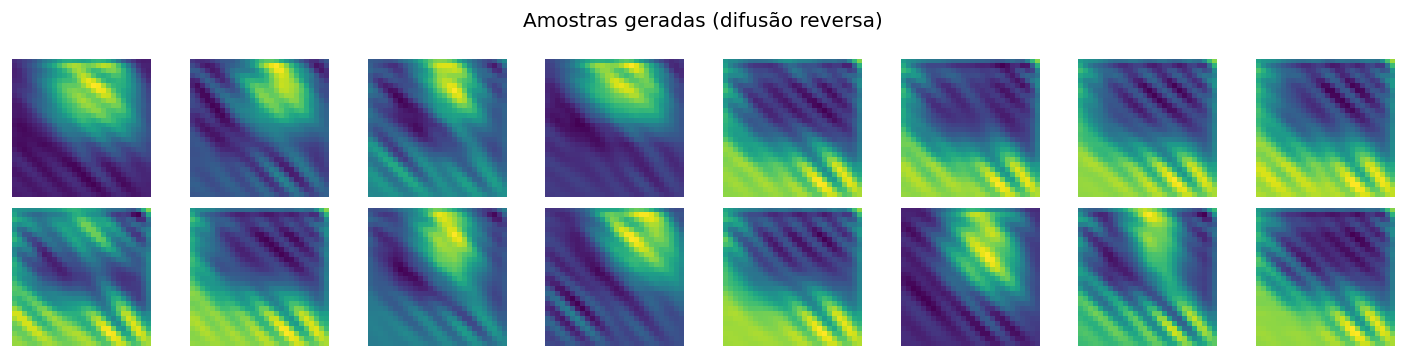

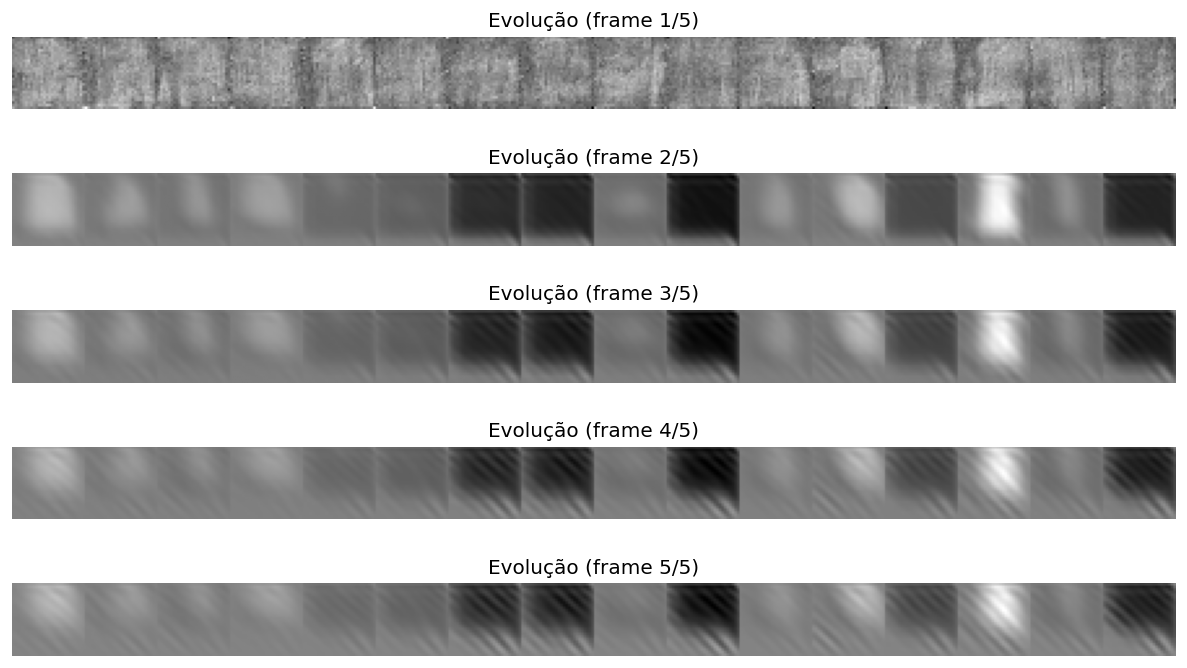

In [9]:
# ============================
# 7) Sampling (passo reverso simplificado)
# ============================
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def p_sample_loop(model, n=16):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    frames = []

    for t_inv in range(T-1, -1, -1):
        t = torch.full((n,), t_inv, device=device, dtype=torch.long)
        eps_pred = model(x, t)

        a_bar = alpha_bar[t].view(-1, 1, 1, 1)
        x0_hat = (x - torch.sqrt(1 - a_bar) * eps_pred) / torch.sqrt(a_bar)

        a = alpha[t].view(-1, 1, 1, 1)
        if t_inv > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)

        x = torch.sqrt(a) * x0_hat + torch.sqrt(1 - a) * z

        if t_inv in [T-1, int(T*0.75), int(T*0.5), int(T*0.25), 0]:
            frames.append(x.clone())

    return x, frames

samples, frames = p_sample_loop(model, n=16)

show_images_color(samples, "Amostras geradas (difusão reversa)", n=16)

plt.figure(figsize=(10, 6))
for i, f in enumerate(frames):
    plt.subplot(len(frames), 1, i+1)
    grid = torch.cat([(img.detach().cpu()+1)/2 for img in f[:16]], dim=2)
    plt.imshow(grid.squeeze(0), cmap="gray")
    plt.axis("off")
    plt.title(f"Evolução (frame {i+1}/{len(frames)})")
plt.tight_layout()
plt.show()


# 8) Exercício (turma)

## A — Experimento (obrigatório)
1. Mude `T` (50/100/200) e compare.

T 50 = Ruído cresce mais rápido e o treino é mais instável, pois o modelo tem menos estágios para aprender.

T 100 = Ruído moderado

T 200 = Ruído adicionado de forma mais suave, com um melhor aprendizado contudo a um custo maior.

Em resumo, quanto maior o T, menos ruído é adicionado a cada passo. Aumentar T implica em melhor qualidade e estabilidade, mas aumenta o custo computacional.

2. Mude `subset_size` (2k/10k/20k) e compare.  

Mais dados resulta em melhor aproxiação da distribuição real, porém exige mais épocas.

3. Aumente `epochs` (GPU) e compare.

Aparentemente o modelo aprende melhor o processo reverso e as amostras geradas ficam menos borradas e com contornos mais definidos, contudo com ganhos marginais após certo ponto.

## B — Perguntas (obrigatório)
- O que `beta_t` controla?  

beta_t define o ritmo com que a imagem vira ruído puro.

- O que `alpha_bar_t` representa?  

alpha_bar_t representa o produto acumulado de alpha, indicando o quanto da imagem original sobrevive ao longo do tempo.

- Por que prever `epsilon`?  

Prever epsilon transforma um problema de geração complexa em regressão simples de ruído.

- Onde entra “aprender distribuição” (ML/DL)?

O modelo aprende como remover ruído corretamente a cada nível t. O DDPM aprende a distribuição indiretamente, aprendendo como voltar do ruído para dados reais, passo a passo.

## C — Projeto (grupo)
- Problema real  
- Sem IA vs com IA  
- Dados, riscos e validação  
- Protótipo: notebook / wireframe + pipeline / vibe coding


# 9) (Opcional) Streamlit
Você pode criar um web app que carrega o checkpoint e mostra frames (ruído → imagem).
